# Face alignment

Face alignment is the second step in face recognition pipeline.

First the algorithm finds landmarks of a face: eyes, nose and mouth (5 points, 2 coordinates for each)

Then the picture is rotated and scaled to put a face vertically, eyes located in preset places.

To locate landmarks we will use a CNN with 10-neurons head (again, 5 x-y pairs).

We will use the CelebA dataset.

Set full train mode

In [1]:
full_train = True

Usual imports.

In [2]:
%matplotlib inline
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import cv2
import tqdm
import os
import gc
import cv2
import copy
import sys
import time
import timm
import mmcv
import math
import shutil
import imghdr
import requests
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
from sklearn import metrics
from IPython.display import clear_output
from torchsummary import summary
from matplotlib import colors
import json

torch.multiprocessing.set_sharing_strategy('file_system')

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'

import warnings
warnings.filterwarnings('ignore')

Constants.

In [3]:
ds_path = '/home/sergey/DATASETS_ML/celebA_full/'
proj_path = os.getcwd()
landmark_path = os.getcwd() + '/models/landmark/'
detefction_path = os.getcwd() + '/models/detection/'

Pin down random (does it even work?).

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

random_seed = 2077
seed_everything(random_seed)

Disable multiple workers for windows.

In [5]:
if 'nt' not in os.name:
    num_workers = 12
else:
    num_workers = 1
print('num_workers =', num_workers)

num_workers = 12


For clearing GPU memory from trash.

In [6]:
def clear_GPU():
    gc.collect()
    torch.cuda.empty_cache()

Find CUDA device.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Some hyperparameters.

In [8]:
batch_size = 32
dataset_divide = 1 if full_train else 400

# Model

We are going to use pretrained CNN (with final pooling) as the backbone. Since the task is quite simple (only 5 coordinate pairs) we wil choose a lightweight and fast backbone.

The model will be downloaded from TIMM: [Documentation](https://rwightman.github.io/pytorch-image-models/feature_extraction/)

Lets look at mobilenet models.

In [9]:
timm.list_models('eff*n*', pretrained=True)

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t']

In [10]:
timm.list_models('mobile*', pretrained=True)

['mobilenetv2_050',
 'mobilenetv2_100',
 'mobilenetv2_110d',
 'mobilenetv2_120d',
 'mobilenetv2_140',
 'mobilenetv3_large_100',
 'mobilenetv3_large_100_miil',
 'mobilenetv3_large_100_miil_in21k',
 'mobilenetv3_rw']

Now - download the v3 large.

In [11]:
# num_classes=0 means there is no classifier at the end
backbone = timm.create_model('efficientnetv2_rw_t', pretrained=True,
                          num_classes=0)
backbone.eval();

The model is optimized for specific image size and normalization. Lets read them

In [12]:
cfg = backbone.default_cfg
if full_train:
    # save cfg for future use of trained network
    json.dump(cfg, open(landmark_path+'best_landmark_model_cfg.txt','w'))
cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnetv2_t_agc-3620981a.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 1.0,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'test_input_size': (3, 288, 288),
 'architecture': 'efficientnetv2_rw_t'}

In [13]:
# extract image preprocessing parameters
stats = cfg['mean'], cfg['std']
img_size = cfg['input_size'][1]

And here is our own model with new "coordinate" head.

In [14]:
class FaceRegressionModel(nn.Module):
    def __init__(self, backbone, num_points=5, hidden_size=2**11):
        '''
        backbone - CNN for reature extraction
        num_points - number of predicted points (each point has two coordinates)
        hidden_size - number of neurons in hidden FC layer before output layer
        '''
        super(FaceRegressionModel, self).__init__()
        self.num_points = num_points
        self.backbone = backbone
        
        self.head = nn.Sequential(
            nn.Flatten(), # now the head can work with any conv result
            nn.LazyLinear(hidden_size),
            nn.LeakyReLU(0.05),
            nn.LazyLinear(num_points * 2)
        )
        
    def forward(self, tensor):
        tensor = self.backbone(tensor)
        tensor = self.head(tensor)
        tensor = tensor.view(tensor.shape[0], self.num_points, -1)
        return tensor

Lets look at layers and their parameters.

In [15]:
model = FaceRegressionModel(backbone)
summary(model.to(device), input_size=(3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
         ConvBnAct-7         [-1, 24, 112, 112]               0
            Conv2d-8         [-1, 24, 112, 112]           5,184
       BatchNorm2d-9         [-1, 24, 112, 112]              48
             SiLU-10         [-1, 24, 112, 112]               0
        ConvBnAct-11         [-1, 24, 112, 112]               0
           Conv2d-12           [-1, 96, 56, 56]          20,736
      BatchNorm2d-13           [-1, 96, 56, 56]             192
             SiLU-14           [-1, 96,

And now lets test the model on a random batch.

In [16]:
test_sample = torch.randn(batch_size, 3, img_size, img_size, device=device)
with torch.no_grad():
    a = model(test_sample)
print(a.shape, a.max(), a.min())
del(a)

torch.Size([32, 5, 2]) tensor(0.0506, device='cuda:0') tensor(-0.0728, device='cuda:0')


# Dataset

We will use CelebA dataset. First lets create a dataframe with all the needed info.

In [17]:
def get_annot_df(ds_path):
    
    bbox = mmcv.list_from_file(ds_path + 'Anno/list_bbox_celeba.txt')[1:]
    bbox = [i.split() for i in bbox]
    cols = bbox[0]
    bbox = bbox[1:]
    bbox = pd.DataFrame(bbox, columns=cols)
    bbox = bbox.set_index('image_id')
    bbox = bbox.astype(int)

    lmarks = mmcv.list_from_file(ds_path + 'Anno/list_landmarks_celeba.txt')[1:]
    lmarks = [i.split() for i in lmarks]
    cols = ['image_id'] + lmarks[0]
    lmarks = lmarks[1:]
    lmarks = pd.DataFrame(lmarks, columns=cols)
    lmarks = lmarks.set_index('image_id')
    lmarks = lmarks.astype(int)

    persons = mmcv.list_from_file(ds_path + 'Anno/identity_CelebA.txt')
    persons = [i.split() for i in persons]
    cols = ['image_id'] + persons[0]
    persons = pd.DataFrame(persons, columns=['image_id', 'person'])
    persons = persons.set_index('image_id')
    persons = persons.astype(int)
    
    partitions = mmcv.list_from_file(ds_path + 'Anno/list_eval_partition.txt')
    partitions = [i.split() for i in partitions]
    partitions = pd.DataFrame(partitions, columns=['image_id', 'part'])
    partitions = partitions.set_index('image_id')
    partitions = partitions.astype(int)
    
    df = bbox.join([persons, lmarks, partitions]).reset_index(drop=False)
    
    df = df.rename(columns=dict(
        x_1 = 'bbox_hor_top',
        y_1 = 'bbox_ver_top',
    ))
    
    for c in df.columns:
        if '_x' in c:
            df[c] = df[c] - df['bbox_hor_top']
        if '_y' in c:
            df[c] = df[c] - df['bbox_ver_top']

    return df

df = get_annot_df(ds_path)

Lets look at the dataframe.

In [18]:
df.head(5)

,image_id,bbox_hor_top,bbox_ver_top,width,height,person,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,part
0,000001.jpg,95,71,226,313,2880,70,113,149,105,101,178,99,200,171,189,0
1,000002.jpg,72,94,221,306,2937,68,110,148,110,96,160,74,195,154,195,0
2,000003.jpg,216,59,91,126,8692,28,45,48,46,47,62,19,75,35,81,0
3,000004.jpg,622,257,564,781,5805,174,282,362,282,308,430,140,499,293,499,0
4,000005.jpg,236,109,120,166,9295,37,60,92,52,62,63,47,99,87,98,0


Here are some options to remove "bad" images from dataset. In the end I used all images without this filter.

In [19]:
if False:
    print(len(df))
    df = df[df['nose_x'] < df['righteye_x']]
    df = df[df['nose_x'] > df['lefteye_x']]
    print(len(df))
    df = df[df['nose_y'] > df['righteye_y']]
    df = df[df['nose_y'] > df['lefteye_y']]
    print(len(df))
    df = df[df['nose_y'] < df['rightmouth_y']]
    df = df[df['nose_y'] < df['leftmouth_y']]
    print(len(df))
    df = df[df['nose_x'] < df['rightmouth_x']]
    df = df[df['nose_x'] > df['leftmouth_x']]
    print(len(df))
    df = df[df['width'] > 90]
    df = df[df['height'] > 110]
    print(len(df))
    df = df[df['lefteye_x'] < df['righteye_x']]
    df = df[df['leftmouth_x'] < df['rightmouth_x']]
    print(len(df))

Now we need some basic augmentations to run our model (or rather out model's backbone).

Albumentations allow us to transform both image and keypoints. For this we must set kwarg keypoint_params.

In [20]:
# keypoints as coordinate pairs
keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)

# list of super basic transforms just to prepare image for the CNN
basic_transform_list = [
                A.Resize(img_size, img_size),
                # A.LongestMaxSize(self.img_size),
                # A.PadIfNeeded(self.img_size, self.img_size, border_mode=0),
                A.Normalize(*stats),
                ToTensorV2(),
            ]
# transform image + keypoints
basic_transform = A.Compose(basic_transform_list, 
                                      keypoint_params=keypoint_params)
# transform image only (for inference)
basic_transform_image_only = A.Compose(basic_transform_list)

And here comes the hard part. We need to create a dataset for the dataloader.

In [21]:
class FaceDataset(Dataset):
    def __init__(self, 
                 df_in, 
                 transform=None, 
                 dataset_divide=1, 
                 noise_k = 0.):
        
        '''
        df_in - dataframe with files and numeric parameters of faces
        transform - custom transformer for training images. For test set None
        dataset_divide - if > 1 dataset is divided and only a part is used
        noise_k - add pixelwise RGB noise with std = noise_k
        '''
        
        global img_size
        global keypoint_params
        global stats
        global basic_transform
        
        self.img_size = img_size
        self.df = df_in
        
        # transform is custom training transform
        self.transform = transform
        self.noise_k = noise_k
        
        if dataset_divide == None:
            dataset_divide = 1
        self.dataset_divide = dataset_divide
        
        # to prepate image for CNN
        self.basic_transform = basic_transform
        
        # horizontal flip has some problems with keypoints... see further
        self.horiz_flip_trans = A.Compose(
            [A.HorizontalFlip(p=1)], keypoint_params=keypoint_params
        )
        
    def __len__(self):
        # dataset_divide > 1 means we use only a part of all images
        if self.dataset_divide > 1:
            return len(self.df) // self.dataset_divide
        else:
            return len(self.df)

    def __getitem__(self, idx):
        
        # get keypoints as X-Y pairs numpy array
        coordinates_x = self.df.iloc[idx][[c for c in self.df.columns if '_x' in c]].values
        coordinates_y = self.df.iloc[idx][[c for c in self.df.columns if '_y' in c]].values
        keypoints = np.stack([coordinates_x, coordinates_y], 1)
        
        # get person ID (just in case)
        person = self.df.iloc[idx, 5]
        
        # get image
        image_filepath = ds_path + 'img_celeba/' + self.df['image_id'].iloc[idx]
        image = cv2.imread(image_filepath)
        
        # now we need to crop image as if we've already detected a face
        x1 = self.df.iloc[idx]['bbox_hor_top']
        x2 = self.df.iloc[idx]['bbox_hor_top'] + self.df.iloc[idx]['width']
        y1 = self.df.iloc[idx]['bbox_ver_top']
        y2 = self.df.iloc[idx]['bbox_ver_top'] + self.df.iloc[idx]['height']
        
        # tricky part - Y is the 0 coord and X is the 1 coord!
        image = image[y1:y2+1, x1:x2+1]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            # horizontal flip. Should be separate to fix left/right features
            if np.random.rand() > 0.5:
                transformed = self.horiz_flip_trans(image=image, keypoints=keypoints)
                image, keypoints_0 = transformed['image'], np.array(transformed['keypoints'])
                keypoints = np.zeros_like(keypoints_0)
                # exchange left-right eye
                keypoints[0,:] = keypoints_0[1,:]
                keypoints[1,:] = keypoints_0[0,:]
                # nose stays the same
                keypoints[2,:] = keypoints_0[2,:]
                # exchange left-right mouth
                keypoints[3,:] = keypoints_0[4,:]
                keypoints[4,:] = keypoints_0[3,:]
                
            # full transform
            transformed = self.transform(image=image, keypoints=keypoints)
            transformed = self.basic_transform(image=transformed['image'], 
                                         keypoints=transformed['keypoints'])

        else:
            # only basic transform for inference
            transformed = self.basic_transform(image=image, keypoints=keypoints)
        
        image = transformed['image']
        keypoints = torch.tensor(transformed['keypoints'])

        # add noise if needed
        if self.noise_k > 0:
            image += torch.randn_like(image) * self.noise_k
        
        # keypoints are relative to the center of the image and normalized by its size
        # so (0,0) point is center
        # (-0.5, -0,5) point is left upper corner
        keypoints = (keypoints - self.img_size / 2) / self.img_size
        
        return image.float(), keypoints

Function to show RGB images after normalizaation.

In [22]:
def denorm(img_tensors):
    img_tensors = img_tensors * stats[1][0] + stats[0][0]
    if type(img_tensors) == torch.Tensor:
        img = img_tensors.cpu().permute(1,2,0).numpy()
    elif type(img_tensors) == np.ndarray:
        img = np.transpose(img_tensors, (1,2,0))
    return img

Same for XY points coordinates.

In [23]:
def restore_xy_pixels_from_float(keypoints):
    global img_size
    return np.array(keypoints) * img_size + img_size / 2

Custom augmentations for training. It's quite aggressive, but it works fine.

In [24]:
color_shift = 10 # default 20
gamma_limit = (30,60)
blur_limit = 3
cutout_size = img_size//7

train_transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, 
                       scale_limit=0.3, 
                       rotate_limit=45, 
                       border_mode=0, value=0),
    A.RGBShift(r_shift_limit=color_shift, 
               g_shift_limit=color_shift, 
               b_shift_limit=color_shift),
    A.HueSaturationValue(),
    A.OneOf([
        A.Sharpen(),
        A.AdvancedBlur(blur_limit=(1, blur_limit)),
    ], p=0.5),
    A.PixelDropout(p=0.2),
    A.ToSepia(p=0.1),
    A.Cutout(num_holes=4, max_h_size=cutout_size, max_w_size=cutout_size)
], keypoint_params=keypoint_params)

Prepare dataloaders.

In [25]:
batch_size = batch_size

train_ds = FaceDataset(df[df['part']==0], 
                       transform=train_transform, 
                       dataset_divide=dataset_divide, 
                       noise_k=0.3)

val_ds = FaceDataset(df[df['part']==1], dataset_divide=dataset_divide)
test_ds = FaceDataset(df[df['part']==2], dataset_divide=dataset_divide)

train_loader = DataLoader(train_ds,
                     batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_loader = DataLoader(val_ds,
                     batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_loader = DataLoader(test_ds,
                     batch_size=batch_size, shuffle=False, num_workers=num_workers)

Show some augmented training images.

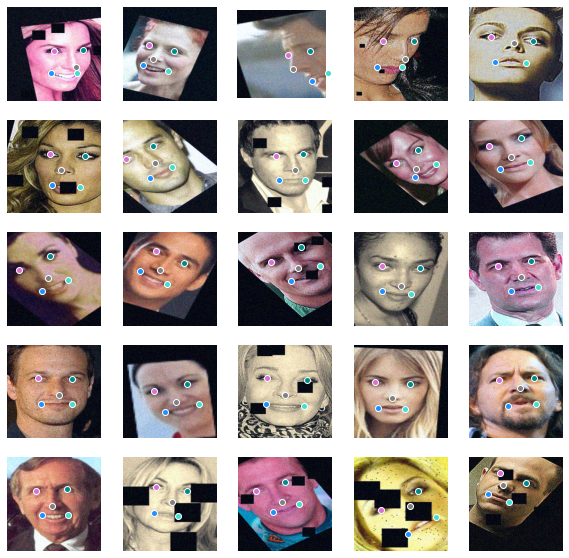

In [26]:
num = 5
fig = plt.figure(figsize=(10,10))
for i in range(num):
    for j in range(num):
        data = train_ds[i*num+j]
        img = denorm(data[0])
        img = np.clip(img, 0, 1)
        keypoints = restore_xy_pixels_from_float(data[1])
        plt.subplot(num, num, i*num+j+1)
        plt.imshow(img)
        plt.axis('off')
        l = len(keypoints)
        D_id_color = [u'orchid', u'darkcyan', u'grey', u'dodgerblue', u'turquoise', u'darkviolet']
        for k in range(l):
            plt.scatter(x=keypoints[k,0], y=keypoints[k,1], color=D_id_color[k], edgecolor='w')
        # plt.scatter(x=keypoints[:,0], y=keypoints[:,1], color='g', edgecolor='w',)
        
plt.show()

Check if dataloader works fine.

In [27]:
for d in train_loader:
    break
d[1].shape

torch.Size([32, 5, 2])

# Loss function

It seems there are lots of regression loss functions used for coordinates regression. One of the most popular is a wing loss [(paper)](https://arxiv.org/pdf/2101.10808v3.pdf). Implementation from [here](https://github.com/elliottzheng/AdaptiveWingLoss).

In [28]:
class WingLoss(nn.Module):
    def __init__(self, omega=15, epsilon=3):
        super(WingLoss, self).__init__()
        self.omega = omega
        self.epsilon = epsilon

    def forward(self, pred, target):
        y = target
        y_hat = pred
        delta_y = (y - y_hat).abs()
        delta_y1 = delta_y[delta_y < self.omega]
        delta_y2 = delta_y[delta_y >= self.omega]
        loss1 = self.omega * torch.log(1 + delta_y1 / self.epsilon)
        C = self.omega - self.omega * math.log(1 + self.omega / self.epsilon)
        loss2 = delta_y2 - C
        return (loss1.sum() + loss2.sum()) / (len(loss1) + len(loss2))

# Helper functions for training

In [29]:
def plot_train_curves(history, name='', best_min=True):
    '''
    plots loss, metric and LR curves
    '''
    train_loss, val_loss, train_metr, val_metr, lr = history['train_loss'], history['val_loss'], history['train_metr'], history['val_metr'], history['lr'], 
    fig = plt.figure(figsize=(6,8))
    fig.patch.set_facecolor('xkcd:white')
    
    plt.subplot(3,1,1)
    # all the stuff with quantiles is used to scale the plot around important part
    points = np.array(train_loss + val_loss, dtype=float)
    points = points[~np.isnan(points)]
    points = points[np.isfinite(points)]
    p = 0.08
    q1, q2 = np.nanquantile(points, p), np.nanquantile(points, 1-p)
    iqr = q2 - q1
    lim1 = max(np.nanmin(points) - iqr * 0.06, q1 - iqr * 1.2)
    lim2 = min(np.nanmax(points) + iqr * 0.06, q2 + iqr * 1.2)
    
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend()
    plt.ylim(lim1, lim2)
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(3,1,2)
    plt.plot(train_metr, label="train_metr")
    plt.plot(val_metr, label="val_metr")
    if best_min:
        my = np.array(val_metr).min()
        mx = np.argmin(np.array(val_metr))
    else:
        my = np.array(val_metr).max()
        mx = np.argmax(np.array(val_metr))
    # show the best metric with red circle
    plt.scatter(x=[mx], y=[my], c='red', s=80)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("metric")

    plt.subplot(3,1,3)
    plt.plot(lr, label="LR")
    plt.xlabel("epochs")
    plt.ylabel("LR")
    plt.yscale('log')
    
    if len(name) > 0:
        plt.suptitle(name)
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.savefig(name+'.png')
    plt.show()

In [30]:
def show_val_pics(pics, gts, preds, name='', history=None,
                  epoch=None, epochs=None, best_metr=None, num=12):
    # choose some random images
    idx = np.random.choice(pics.shape[0], num, replace=False)
    fig = plt.figure(figsize=(10,5))
    for k in range(num):
        n = idx[k]
        img = pics[n]
        size = img.shape[1]
        
        # prepare and show image
        img = denorm(img)
        img = np.clip(img, 0, 1)
        plt.subplot(2, num//2, k+1)
        plt.imshow(img, cmap='gray')
        
        # prepare and show landmarks
        gt, pred = gts[n], preds[n]
        pic_mae = metrics.mean_absolute_error(gt.flatten(), pred.flatten())
        gt = restore_xy_pixels_from_float(gt)
        pred = restore_xy_pixels_from_float(pred)
        l = len(gt)
        D_id_color = [u'orchid', u'darkcyan', u'grey', u'dodgerblue', u'turquoise', u'darkviolet']
        for i in range(l):
            plt.scatter(x=gt[i,0], y=gt[i,1], color=D_id_color[i], edgecolor='w')
            plt.scatter(x=pred[i,0], y=pred[i,1], color=D_id_color[i], marker='x', s=200)
        plt.title(f'MAE: {pic_mae:.4f}')
        plt.axis('off')

    # add text info to the plot
    if history is not None:
        train_m = history['train_metr'][-1]
        val_m = history['val_metr'][-1]
        s = f'{name}   Epoch: {epoch+1}/{epochs}   train metric: {train_m:.4f}   valid metric: {val_m:.4f}   [best metric {best_metr:.4f}]'
        plt.suptitle(s)        
        
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.show()

In [31]:
def single_epoch(model, optimizer, loss_fn, data_loader, metric, mode='val', batches_to_save=10):
    
    '''
    iterates through a dataloader and optionally trains model
    model - model to be trained or evaluated
    optimizer - optimizer for the model. For eval can be set to None
    loss_fn - loss function. Takes two tensors
    data_loader - image + keypoints dataloader
    metric - metric function. Takes two arrays
    mode - 'val' for evaluate or 'train' else for training
    batches_to_save - number of batches of images (np arrays) to save.
        Used during eval to show some pictures
    '''
    
    torch.set_grad_enabled(mode == 'train')
    if mode == 'train':
        model.train()
    else:
        model.eval()
    
    pics = [] # images to save for plotting
    gts = [] # real landmarks
    preds = [] # predicted landmarks
    losses = [] # array for losses to keep track

    for _, batch in enumerate(tqdm(data_loader)):
        
        X_batch = batch[0]
        Y_batch = batch[1]
        
        # save pictures
        if mode=='val' and len(pics) < batches_to_save:
            pics.append(X_batch.detach().numpy())
        
        # save real landmarks
        gts.append(Y_batch.detach().numpy())
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        if mode == 'train': optimizer.zero_grad()

        pred = model(X_batch)
        preds.append(pred.cpu().detach().numpy())
        loss = 0
        # here is a trick: we want more precision for eyes, so we give them more weight
        loss += loss_fn(pred[:,0:2,:], Y_batch[:,0:2,:].to(torch.float32))
        loss += 0.1 * loss_fn(pred[:,2:,:], Y_batch[:,2:,:].to(torch.float32))
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            
        loss = loss.cpu().detach().item()
        losses.append(loss)

    # at the end if epoch all lists are turned to np arrays
    if mode=='val':
        pics = np.concatenate(pics, axis=0)
    
    gts = np.concatenate(gts, axis=0)
    preds = np.concatenate(preds, axis=0)

    epoch_loss = np.array(losses).mean()
    epoch_metr = metric(preds.flatten(), gts.flatten()).mean()
    
    torch.set_grad_enabled(True)
    model.eval()
    
    return dict(pics=pics, gts=gts, preds=preds, loss=epoch_loss, metr=epoch_metr)

In [32]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val, 
             metric, best_min_metr=True, scheduler=None, 
             plots=True, set_best_params=True, name=''):
    
    # calculate default metric and set it as "the best"
    val_res = single_epoch(model, optimizer, loss_fn, data_val, metric, mode='val')
    best_metr = val_res['metr']
    best_loss = val_res['loss']
    print(f'before training: val_loss: {best_loss:.2f}    val_metr: {best_metr:.2f}')
    best_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    # empty training history
    history = dict(
        train_loss = [],
        val_loss = [],
        train_metr = [],
        val_metr = [],
        lr = []
    )

    for epoch in range(epochs):
            
        print(f'Epoch {epoch+1}/{epochs}, best = {best_epoch}', end='    ')
        history['lr'].append(optimizer.param_groups[0]["lr"])
        
        # training
        train_res = single_epoch(model, optimizer, loss_fn, data_tr, metric, mode='train')
        history['train_loss'].append(train_res['loss'])
        history['train_metr'].append(train_res['metr'])

        # validation
        val_res = single_epoch(model, optimizer, loss_fn, data_val, metric, mode='val')
        pics = val_res['pics']
        gts = val_res['gts']
        preds = val_res['preds']
        history['val_loss'].append(val_res['loss'])
        history['val_metr'].append(val_res['metr'])
        
        # print epoch result
        tr_loss = history['train_loss'][-1]
        tr_metr = history['train_metr'][-1]
        val_loss = history['val_loss'][-1]
        val_metr = history['val_metr'][-1]
        
        # we want to plot images after each epoch, so need to clear output
        if plots and epoch > 1:
            clear_output(wait=True)
        
        print(f'tr_loss: {tr_loss:.2f}  tr_metr: {tr_metr:.2f}' + \
              f'   val_loss: {val_loss:.2f}  val_metr: {val_metr:.2f}')
        
        # if best epoch: save weights
        if (history['val_metr'][-1] <= best_metr) * (-1+2*int(best_min_metr)):
            print('new best val metric!')
            best_epoch = epoch + 1
            best_metr = history['val_metr'][-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            model_file_name = landmark_path+'tmp_landmark_model_weights.pt'
            try: os.remove(model_file_name)
            except: pass
            torch.save(model, model_file_name)

        # scheduler step (if needed)
        if scheduler != None: scheduler.step(history['val_loss'][-1])

        # visualize
        if plots:
            try: show_val_pics(pics, gts, preds, name, history, epoch, epochs, best_metr)
            except Exception as e: print(e)
            if epoch > 1:
                try:
                    plot_train_curves(history, name)
                except Exception as e:
                    print(e)
                    
    
    # load best weigts if needed
    if set_best_params:
        model.load_state_dict(best_model_wts)
        print(f'Weights loaded from best epoch {best_epoch}, metric = {best_metr:.2f}')
            
    return(history)

# Training

tr_loss: 0.04  tr_metr: 0.01   val_loss: 0.02  val_metr: 0.01
new best val metric!


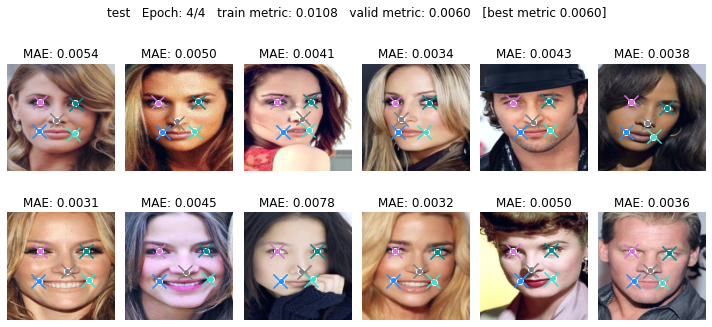

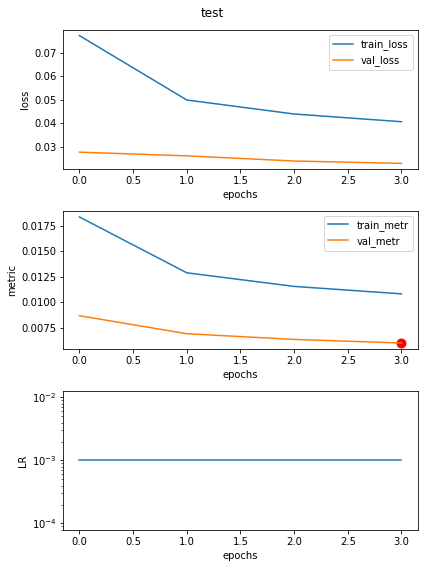

Weights loaded from best epoch 4, metric = 0.01
CPU times: user 53min 53s, sys: 17min 16s, total: 1h 11min 10s
Wall time: 1h 11min 3s


In [33]:
%%time
clear_GPU()
model.to(device)
# loss_fn = nn.MSELoss()
# loss_fn = nn.SmoothL1Loss()
loss_fn = WingLoss()
metr = metrics.mean_absolute_error
lr = 1e-3
weight_decay = 1e-3
epochs = 4
opt_type = torch.optim.Adam # W

optimizer = opt_type(model.parameters(), 
                     lr=lr, 
                    # weight_decay=weight_decay
                    )

h = train(model=model, optimizer=optimizer, loss_fn=loss_fn, 
             epochs=epochs, data_tr=train_loader, data_val=val_loader, metric=metr, 
             scheduler=None, name='test')

Save model after full training.

In [34]:
if full_train:
    torch.save(model, landmark_path+'best_landmark_model.pt')
else:
    model = torch.load(landmark_path+'best_landmark_model.pt')

# Inference time!

We want to run inference on CPU, so use device=CPU.

First load the detector.

In [35]:
weigths_file = detefction_path+'best.pt'
model_detect = torch.hub.load('ultralytics/yolov5', 'custom', 
                              path=weigths_file, force_reload=True, device='cpu')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/sergey/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-7-15 Python-3.9.7 torch-1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


Then move landmark regressor to CPU.

weigths_file_detect = './yolov5/runs/train/exp4/weights/best.pt'
model_detect = torch.hub.load('ultralytics/yolov5', 
                              'custom', 
                              path=weigths_file_detect, 
                              force_reload=True)

In [36]:
model.to('cpu')
model.eval();

And here is sone matrix magic. We want to align an image to place eyes to specific points. Here is a function for that.

[Here is a source for the fuction](https://github.com/PyImageSearch/imutils/blob/master/imutils/face_utils/facealigner.py)

In [37]:
def align(image, 
          old_centers, 
          desiredLeftEye=(0.35, 0.4), 
          desiredFaceWidth=224, 
          desiredFaceHeight=None):

    if desiredFaceHeight is None:
        desiredFaceHeight = desiredFaceWidth

    leftEyeCenter = old_centers[0]
    rightEyeCenter = old_centers[1]

    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) # - 180

    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]

    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= desiredFaceWidth
    scale = desiredDist / dist

    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
        (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

    # update the translation component of the matrix
    tX = desiredFaceWidth * 0.5
    tY = desiredFaceHeight * desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])

    # apply the affine transformation
    (w, h) = (desiredFaceWidth, desiredFaceHeight)
    output = cv2.warpAffine(src=image, M=M, dsize=(w, h),
        flags=cv2.INTER_CUBIC)

    # return the aligned face
    return output

And now real inference! With webcam.

QObject::moveToThread: Current thread (0x5591ca6f0f30) is not the object's thread (0x5591ccdba120).
Cannot move to target thread (0x5591ca6f0f30)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

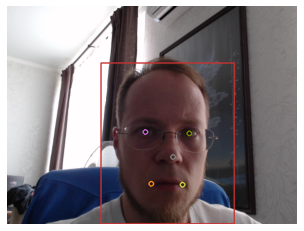

In [38]:
# cv2 wants to have colors in RGB not in string...
D_id_color = [u'orchid', u'darkcyan', u'grey', u'dodgerblue', u'turquoise', u'darkviolet']
D_id_color = [(np.array(colors.to_rgb(i))*255).round() for i in D_id_color]

# need time to calculate FPS
t_start = time.time()
frames = 0

# try to free the camera if it is occupied
try:
    video_capture.release()
except: pass

# use camera 0
video_capture = cv2.VideoCapture(0)

# dummy of cropped face image
newim = None

while True:
    # time.sleep(0.08)
    frames += 1
    
    # capture frame-by-frame
    # frame is numpy array with BGR colors
    return_status, frame = video_capture.read()
    
    # get RGB picture
    RGB_img = frame[:,:,::-1].copy() # np.copy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # detection model YOLO has built-it preprocessing
    results = model_detect(RGB_img)
    
    # index [0] means first in batch (even 1 pic is a batch)
    # [-2] means we don't need class and prob
    results = results.xyxy[0].cpu().numpy()[:,:-2]
    
    # iterate through all faces
    for face_num, row in enumerate(results):
        
        # row = row.astype(int)
        
        # get int coords of bbox
        x1 = int(row[0])
        x2 = int(row[2])
        y1 = int(row[1])
        y2 = int(row[3])
        
        # again - get RGB pic
        face_cut_orig = np.copy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        # cut out the face (important! Here y is the first coordinate!)
        face_cut_orig = face_cut_orig[y1:y2, x1:x2]
        
        # preprocess for torch model
        face_cut = basic_transform_image_only(image=face_cut_orig)['image']
        
        # create a "batch" from image
        face_cut = face_cut.unsqueeze(0)

        # predict
        with torch.no_grad():
            coordinates = model(face_cut)
        
        # remove "batch" dim
        coordinates = coordinates.squeeze(0).detach().numpy()
        
        # transform relative coords to pixel
        coordinates[:,0] = (row[2]+row[0])/2 + coordinates[:,0] * (row[2]-row[0])
        coordinates[:,1] = (row[3]+row[1])/2 + coordinates[:,1] * (row[3]-row[1])
        
        newim = align(image=frame, old_centers=coordinates[:2,:])
        # print(coordinates[:2,:])
        cv2.imshow(str(face_num), newim.copy())
        
        # draw circles
        l = len(coordinates)
        # D_id_color = [(255,0,0), (0,255,0), (125,125,125), (255,0,150), (0,150,150)]
        for i in range(l):
            cv2.circle(frame, 
                       center=(int(coordinates[i,0]), int(coordinates[i,1])), 
                       color=D_id_color[i], 
                       radius=5,
                       thickness=2)
            
        # draw rect around face
        cv2.rectangle(frame, (x1,y1), 
                      (x2,y2), (50, 50, 200), 2)
        
    # display the resulting frame
    cv2.imshow('Video', frame.copy())

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or key == ord('й'):
        break
    elif key == ord('c') or key == ord('с'):
        # capture and show one frame
        RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img)
        plt.axis('off')
        plt.show()
        
        # show cropped face!
        if newim != None:
            RGB_img = cv2.cvtColor(newim, cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.axis('off')
            plt.show()
        
# when everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

# calculate FPS
t = time.time() - t_start
print('FPS', frames/t)

It works!

Next step - create a single universal class for detection and alignment.